# Tutorial for vaex as a library
## Introduction
This tutorial shortly introduces how to use vaex from IPython notebook. This tutorial assumes you have vaex installed as a library, you can run `python -c 'import vaex'` to check this.
This document although not a IPython notebook, is generated from a notebook, and you should be able to reproduce all examples.

## Run IPython notebook
From the <a href='http://ipython.org/notebook.html'>IPython notebook website:</a>
> The IPython Notebook is an interactive computational environment, in which you can combine code execution, rich text, mathematics, plots and rich media

To start it, run `$ ipython notebook` in your shell, and it should automatically open the main webpage. Start a new notebook by clicking `new`.

## Starting
Start you notebook by importing the relevant packages, for this tutorial, we will be using vaex itself, <a href="www.nupmy.org">numpy</a> and <a href="matplotlib.org">matplotlib</a> for plotting. We also configure matplotib to show the plots in the notebook itself

In [1]:
import vaex as vx
import numpy as np
import pylab # simpler interface for matplotlib
# next line configures matplotlib to show the plots in the notebook, other option is qt to open a dialog
%matplotlib inline

/Users/users/breddels/.local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


## Open a dataset
To open a dataset, we can call vx.open to open local files. See the documentation of <a href=''>vaex.open</a> for the arguments, or run `vx.open?` in the notebook for direct help. For this tutorial we use `vx.example()` which opens a dataset provided with vaex.

In [2]:
dataset = vx.example()
# dataset = vx.open('yourfile.hdf5') # in case you want to load a different dataset

You can get information about the dataset, such as the columns by simply typing `dataset` as the last command in a cell.

In [3]:
dataset

To get a list with all column names, use Dataset's get_column_names method. Note that tab completion should work, typing `dataset.get_c` and then pressing type should help.


In [4]:
dataset.get_column_names()

['x', 'y', 'z', 'vx', 'vy', 'vz', u'E', u'FeH', u'L', u'Lz', u'random_index']

## Using subspaces
Since we often work with a few columns, for instance 2 when we want to do plot, we create a `vaex.dataset.Subspace` from the dataset. 

In [5]:
subspace_xy = dataset("x", "y")

Subspace contain methods to compute statistics, n dimensional histograms, and convenient plotting routines.

In [6]:
print "means", subspace_xy.mean()
print "variance", subspace_xy.var()
xlimits, ylimits = subspace_xy.minmax()
print "(xmin, xmax) =", xlimits
print "(ymin, ymax) =", ylimits

means [-0.06713149 -0.05358987]
variance [ 53.54972406  60.62545068]
(xmin, xmax) = [-128.293991  271.365997]
(ymin, ymax) = [ -71.5523682  146.465836 ]


In [7]:
limits = subspace_xy.limits_sigma(square=True) # create boundaries around the mean with +/-3 sigma
# square=True forces the boundaries to be square by taking for sigma the mean sigma
grid = subspace_xy.histogram(limits)

Grid in this case is a two dimensional numpy array, which we will use for plotting. In this case it is 256x256, but you can pass an integer as argument to histogram to change the size (e.g. `subspace_xy.histogram(limits, size=128)`.

In [8]:
print "grid shape", grid.shape
print grid.sum(), "of a total of ", len(dataset), "objects are visible"

grid shape (256, 256)
321201.0 of a total of  330000 objects are visible


## Plotting
Now that we have 2d histogram, we can plot this using matplotlib, by using `pylab.imshow` (hint: use `pylab.imshow?` for help).

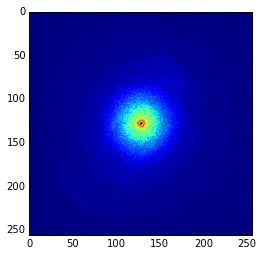

In [9]:
pylab.imshow(grid)

Matplotlib by default will show the image 'upside down', and it does not have information about the axis.

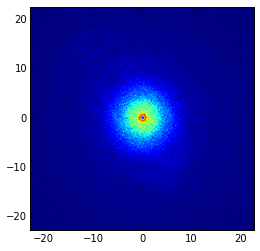

In [10]:
pylab.imshow(grid, extent=limits.flatten(), origin='lower')

You can also use subspace_xy.plot(grid, limits) 

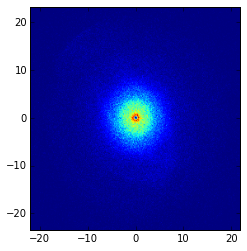

In [11]:
subspace_xy.plot(grid, limits)

A quicker way, but possibly less flexible is to use the Subspace.plot method without any arguments. By default it will calculated the limits of the subspace as above (by using limits_sigma) and will make a histogram of 256x256 and plot with the default colormap of matplotlib.

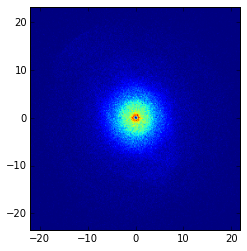

In [12]:
subspace_xy.plot()

If you are using IPython notebook, you can find documentation about Subspace.plot by having the cursor near that method and hitting shift-tab (or multiple times for more documentation). Otherwise see http://www.astro.rug.nl/~breddels/vaex/vaex.html#vaex.dataset.Subspace.plot for online documentation. Or look at the prettified sourcecode at http://www.astro.rug.nl/~breddels/vaex/_modules/vaex/dataset.html#Subspace.plot .

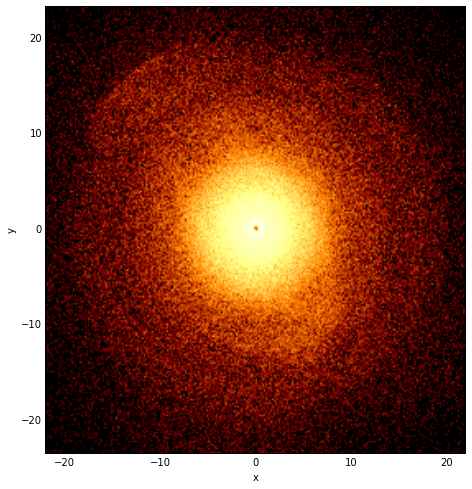

In [24]:
subspace_xy.plot(f=lambda x: np.log(1+x), figsize=(8,8), cmap="afmhot", xlabel="x", ylabel="y")

## Selections
For working with a part of the data, we introduce the concept of selections. When a selection is applied to a dataset, it keeps a boolean in memory for each row indicating it is selected or not. All operations applied to a (selected) subspace then will only use the rows that are selected.

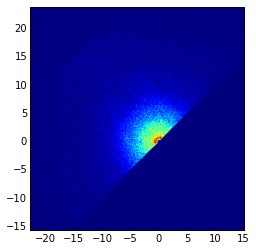

In [32]:
dataset.select("y > x")
subspace_xy_selected = subspace_xy.selected()
subspace_xy_selected.plot()


Selection can be made more complicated, or can be logically combined using a boolean operator. The default is to replace the current selections, other possiblities are: "replace", "and", "or", "xor", "subtract"

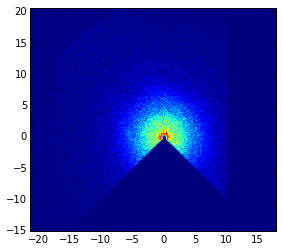

In [34]:
dataset.select("y > x")
dataset.select("y > -x", mode="or")
dataset.select("x > 10", mode="subtract")
subspace_xy_selected.plot()

Besides making plots, statisics etc can also be computed for selections

In [35]:
print subspace_xy_selected.minmax()
print subspace_xy_selected.mean()

[[-128.293991      9.99912262]
 [ -62.4985847   146.465836  ]]
[-1.69959942  2.88560843]


## Virtual columns
If a particular expression occurs often, it may be convenient to create a virtual column, it behaves exactly like a normal column, but it is calculated on the fly (without taking up the memory of a full column, since it is done is chunks).

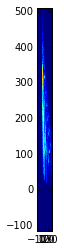

In [42]:
dataset.add_virtual_column("r", "sqrt(x**2+y**2+z**2)")
dataset.add_virtual_column("v", "sqrt(vx**2+vy**2+vz**2)")
dataset("r", "v").plot() # TODO: why isn't aspect working

In [15]:
#limits = subs.minmax(Alpha=[20, None], Delta[])
subs.mutual_information()

[0.063728206742057453,
 0.10521150627830662,
 0.042733842552512231,
 0.11204217145966548,
 0.061805487339593401,
 0.31687483357631618,
 0.051735227335376312,
 0.12136947479395965,
 0.14373706858217078,
 0.28357264450786146,
 0.14174165252248322,
 0.13162209633032604,
 0.057099302440003379,
 0.072782769168485792,
 0.38231476402015974,
 0.067762236726809894,
 0.15173591172010609,
 0.17858442520891243,
 0.33455700979856284,
 0.083899141608947236,
 0.081207902608447624,
 0.068143104083898384,
 0.35453160198993311,
 0.099054015018225264,
 0.17126940706562738,
 0.2139311542365647,
 0.49090455534859662,
 0.071119625328516831,
 0.087913176505271723,
 0.067278361248549773,
 0.066378036745202845,
 0.085665976634166349,
 0.0944175393374133,
 0.10708588458094538,
 0.093375580437939421,
 0.064681091886318987,
 0.066648454757023995,
 0.084622776585355594,
 0.089469185255066641,
 0.10694474904483861,
 0.07779993437156324,
 0.077789800203446224,
 0.10511512286385023,
 0.10069540131846931,
 0.163108698

In [16]:
#subs = ds("x" ,"y")
dataset.select(" x > 1")

[0]

In [17]:
subspace = dataset("y", "z").selected()

In [18]:
subspace.mutual_information()

0.17199457598979478

In [19]:
import yaml

In [20]:
data= {"bla": 1, "people": ["jovan", "maarten"]}

In [21]:
print yaml.dump(data)

bla: 1
people: [jovan, maarten]



In [22]:
d = yaml.load("""colums:
 - x
 - y
 - z
mutual_information:
 x-y: 1
 y-z: 2""")

In [23]:
d["mutual_information"]["x-y"]

1